# \[STAT-315\] Bikeshare Insights Data Analysis Project

#### Defining the questions:
We first ask the following questions:
1. Can we predict which casual riders are most likely to benefit from a membership, enabling targeted promotional strategies?
2. Are there any seasonal or temporal patterns in ridership behavior that could be used to optimize station positioning and bike allocations to stations?
3. Which factors (such as membership status, trip length, bike type, day of week, or station location) most strongly influence whether a rider chooses an electric versus a classic bike, and how much do these factors impact overall demand?


#### Data collection

For our given questions, we decide to leverage the Divvy dataset previously used for our mini-project. Simply run the following cell to obtain the bike sharing insights data for the year of 2023. It will be stored in `./data/`.

In [2]:
!python combine.py

/Users/leon/Documents/GitHub/stat-315-final-project/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Reading all Divvy .csv files.: 100%|████████████| 12/12 [00:06<00:00,  1.75it/s]
Creating concatenated .csv file.
Successfully created merged .csv file. Path is ./data/2023-divvy-tripdata.csv


#### Data cleaning and preparation
We then prepare the data for our analysis by cleaning out unusual rows and adding additional features.

In [1]:
# required imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# loading data
divvy_df = pd.read_csv("./data/2023-divvy-tripdata.csv", index_col=0)
divvy_df = divvy_df.reset_index(drop=True)

In [3]:
# get rid of abnormally long or short ride times (<1 minute or >2 hours)
divvy_df["started_at"] = pd.to_datetime(divvy_df["started_at"])
divvy_df["ended_at"] = pd.to_datetime(divvy_df["ended_at"])

divvy_df["ride_duration_min"] = (divvy_df["ended_at"] - divvy_df["started_at"]).astype('int64') / 60_000_000_000

divvy_df = divvy_df[(1 <= divvy_df["ride_duration_min"]) & (divvy_df["ride_duration_min"] <= 120)]

In [4]:
# get rid of abnormally long distances
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    lat1_rad, lon1_rad = np.radians(lat1), np.radians(lon1)
    lat2_rad, lon2_rad = np.radians(lat2), np.radians(lon2)
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

divvy_df["distance_km"] = haversine(
    divvy_df["start_lat"],
    divvy_df["start_lng"],
    divvy_df["end_lat"],
    divvy_df["end_lng"]
)

divvy_df = divvy_df[(divvy_df["distance_km"] <= 15) & (divvy_df["distance_km"] > 0.1)]

In [5]:
# adds season to dataframe
def season(month: int):
    if month in [1, 2, 12]:
        return "winter"
    elif month in [3, 4, 5]:
        return "spring"
    elif month in [6, 7, 8]:
        return "summer"
    else:
        return "fall"
    
divvy_df["season"] = divvy_df["started_at"].dt.month.apply(season)

In [6]:
# add km/hr to dataset, removing abnormally low values
# they have significantly higher ride times (~1 hr)
divvy_df["avg_velocity_km_per_hr"] = divvy_df["distance_km"] / (divvy_df["ride_duration_min"] / 60)
divvy_df = divvy_df[divvy_df["avg_velocity_km_per_hr"] > 2]

#### Data analysis

We first create additional features such as factoring in time by separating the timestamps into month and days, then cyclically encoding their values to better capture the relationship. Also, some columns are dropped such as the station name and ID, since there is no meaningful information from using those as they're captured in the longitude and latitude.

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.calibration import CalibratedClassifierCV

from xgboost import XGBClassifier

from catboost import CatBoostClassifier

In [8]:
ml_divvy_df = divvy_df.copy()

# maybe consider adding station_id/station
# obtains only cols that can be used for features in the model

# creates the target column
Y_df = divvy_df["member_casual"]
Y_df = Y_df.map({
    "member": 1,
    "casual": 0
})

# columns to drop after creating new features
drop_cols = [
    "ride_id", 
    "started_at", "ended_at", 
    "start_station_name", "start_station_id", 
    "end_station_name", "end_station_id", 
    "avg_velocity_km_per_hr",
    "member_casual"
]

def encode_cyclical(col, period):
    return FunctionTransformer(lambda x: np.hstack([
        np.sin(2 * np.pi * x / period),
        np.cos(2 * np.pi * x / period)
    ]))

# generates new features from date
ml_divvy_df["month"] = divvy_df["started_at"].dt.month
ml_divvy_df["day"] = divvy_df["started_at"].dt.day
ml_divvy_df["weekday"] = divvy_df["started_at"].dt.weekday

# columns to process in transformer
one_hot_encode_cols = ["rideable_type", "season", "weekday"]
numeric_cols = ["start_lat", "start_lng", "end_lat", "end_lng", "ride_duration_min", "distance_km"]

We then apply transformations such as one-hot-encoding certain categorical variables as well as drop the meaningless columns.

Once the final dataset is obtained, we then fit them to various models and obtain the ROC-AUC curve, since we care about ranking casual users based on how "member-like" they are. We use cross-validation to utilize the same dataset to find the best model in terms of our desired metric.

In [ ]:
# creates one-hot-encoded representations and removes improper data 
preprocessor = ColumnTransformer(
    transformers=[
        ("one_hot_encode", OneHotEncoder(), one_hot_encode_cols),
        ("month_cyclical", encode_cyclical("month", 12), ["month"]),
        ("day_cyclical", encode_cyclical("day", 31), ["day"]),
        ("weekday_cyclical", encode_cyclical("weekday", 7), ["weekday"]),
        ("scale", StandardScaler(), numeric_cols),
        ("drop", "drop", drop_cols),
    ],
    remainder="passthrough"
)

SEED = 1

models = {
    "LogReg": LogisticRegression(
        max_iter=5000,
        solver="liblinear",
        penalty="l2",
        random_state=SEED
    ),
    "Support Vector Machine (SVM)": svm.LinearSVC(),
    "XGBoost": XGBClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.9,
        colsample_bytree=0.9,
        eval_metric="logloss",
        tree_method="hist",
        random_state=SEED
    ),
    "CatBoost": CatBoostClassifier(
        iterations=300,
        depth=6,                   
        learning_rate=0.1,
        l2_leaf_reg=3.0,       
        loss_function="Logloss",
        bootstrap_type="Bayesian",
        verbose=False,
        random_state=SEED
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=150,
        max_depth=20,
        min_samples_split=20,
        min_samples_leaf=10,
        max_features="sqrt",
        max_samples=0.7,
        class_weight="balanced",
        random_state=SEED
    ),
}

Once we've obtained the models we want to evaluate, we then iterate through each to determine which results in the best ROC-AUC value using cross validation with 5 folds.

In [ ]:
# model_scores = []

# for i, (name, model) in enumerate(models.items()):
#     pipeline = Pipeline([
#         ("prep", preprocessor),
#         ("classifier", model)
#     ])

#     score = cross_val_score(
#         pipeline, 
#         ml_divvy_df, Y_df,
#         cv=5,
#         scoring="roc_auc"
#     )
    
#     print(f"{name}:")
#     print(f"Average ROC-AUC score:\n{score.mean():.4f}")
#     print()

Then once each training pipeline finishes, we obtain the average ROC-AUC score among each model, where we see that SVMs perform the best. Thus, we will use this model for further exploratory analysis.

| **Model**                    | **Average ROC-AUC** |
| ---------------------------- | ------------------- |
| Support Vector Machine (SVM) | **0.6232**              |
| XGBoost                      | 0.5992              |
| Logistic Regression (LogReg) | 0.6210              |
| CatBoost                     | 0.6152              |
| Random Forest                | 0.5863              |


In [ ]:
X_casual_df = ml_divvy_df[ml_divvy_df["member_casual"] == "casual"].drop(columns=["member_casual"])

# retrain model
svm_model = svm.LinearSVC()
model = CalibratedClassifierCV(svm_model, cv=5)

best_pipeline = Pipeline([
    ("prep", preprocessor),
    ("classifier", model)
])

best_pipeline.fit(ml_divvy_df, Y_df)

probabilities = pd.DataFrame(best_pipeline.predict_proba(X_casual_df)[:, 1])

candidates_df = X_casual_df.copy()
candidates_df["member_probability"] = probabilities

top_5_prob = probabilities.quantile(0.95).item()

top_candidates_df = candidates_df[candidates_df["member_probability"] >= top_5_prob]
bot_candidates_df = candidates_df[candidates_df["member_probability"] < top_5_prob]

Once we have the 95% percentile of casual members, we then perform an exploratory analysis to determine whether they exihibit similar behaviors to the Divvy members.

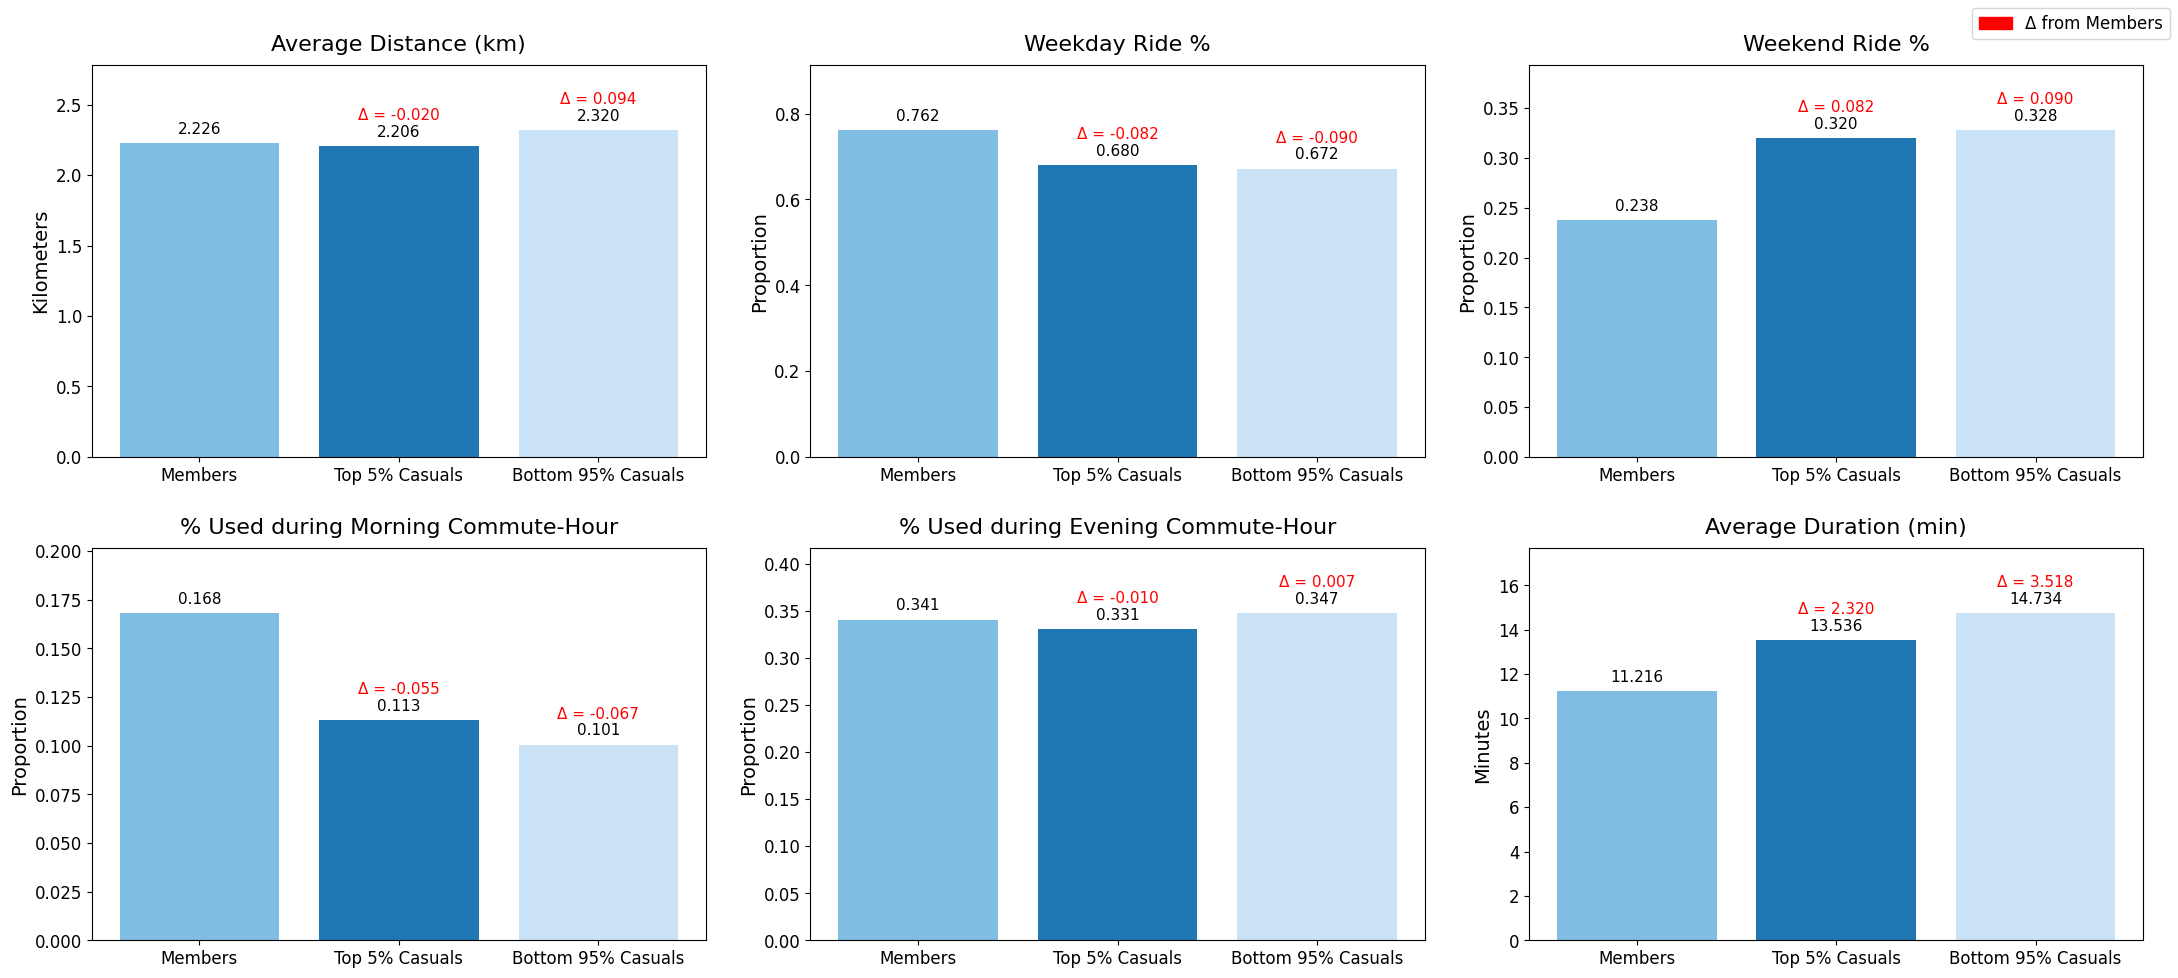

In [54]:
from matplotlib.patches import Patch

members_df = ml_divvy_df[ml_divvy_df["member_casual"] == "member"]

plt.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12
})
groups = ["Members", "Top 5% Casuals", "Bottom 95% Casuals"]

distance_vals = [
    members_df["distance_km"].mean(),
    top_candidates_df["distance_km"].mean(),
    bot_candidates_df["distance_km"].mean()
]

wkday_vals = [
    (members_df["weekday"] <= 4).mean(),
    (top_candidates_df["weekday"] <= 4).mean(),
    (bot_candidates_df["weekday"] <= 4).mean()
]

wkend_vals = [
    (members_df["weekday"] > 4).mean(),
    (top_candidates_df["weekday"] > 4).mean(),
    (bot_candidates_df["weekday"] > 4).mean()
]

TO_COMMUTE_HOURS = [7,8,9]
FROM_COMMUTE_HOURS = [16,17,18,19]

to_commute_vals = [
    members_df["started_at"].dt.hour.isin(TO_COMMUTE_HOURS).mean(),
    top_candidates_df["started_at"].dt.hour.isin(TO_COMMUTE_HOURS).mean(),
    bot_candidates_df["started_at"].dt.hour.isin(TO_COMMUTE_HOURS).mean()
]

from_commute_vals = [
    members_df["started_at"].dt.hour.isin(FROM_COMMUTE_HOURS).mean(),
    top_candidates_df["started_at"].dt.hour.isin(FROM_COMMUTE_HOURS).mean(),
    bot_candidates_df["started_at"].dt.hour.isin(FROM_COMMUTE_HOURS).mean()
]

duration_vals = [
    members_df["ride_duration_min"].mean(),
    top_candidates_df["ride_duration_min"].mean(),
    bot_candidates_df["ride_duration_min"].mean()
]

all_metrics = {
    "Average Distance (km)": (distance_vals, "Kilometers"),
    "Weekday Ride %": (wkday_vals, "Proportion"),
    "Weekend Ride %": (wkend_vals, "Proportion"),
    "% Used during Morning Commute-Hour": (to_commute_vals, "Proportion"),
    "% Used during Evening Commute-Hour": (from_commute_vals, "Proportion"),
    "Average Duration (min)": (duration_vals, "Minutes")
}

fig, axes = plt.subplots(2, 3, figsize=(22, 10))
axes = axes.flatten()

colors = ["#7fbde3", "#1f77b4", "#c9e2f5"]

for ax, (title, (values, ylabel)) in zip(axes, all_metrics.items()):

    bars = ax.bar(groups, values, color=colors)

    ymax = max(values)
    ax.set_ylim(0, ymax * 1.20)

    # Labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + ymax * 0.02,
            f"{height:.3f}",
            ha='center',
            va='bottom',
            fontsize=11
        )

    # Δ annotations (also lowered)
    member_val = values[0]
    for i in [1, 2]:
        diff = values[i] - member_val
        bar = bars[i]
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + ymax * 0.08,
            f"Δ = {diff:.3f}",
            ha='center',
            color="red",
            fontsize=11
        )

    ax.set_title(title, pad=10)
    ax.set_ylabel(ylabel)

# Remove unused subplot if only 5 metrics
if len(all_metrics) < 6:
    fig.delaxes(axes[-1])

delta_patch = Patch(color="red", label="Δ from Members")

fig.legend(
    handles=[delta_patch],
    loc="upper right",
    ncol=3,
    fontsize=12
)

plt.tight_layout(pad=2.0)
plt.show()

#### Interpretation and Results

Once we've obtained the top 5% most likely casual users that exhibit similar behavior to members, we then introduce 6 metrics in order to compare members to the top 5% casual users along with the bottom 95%.

Based on the results of the graph, we notice that the magnitude difference between the top 5% casuals most similar to members and the members is smaller than the difference between the bottom 95% of casual users and members. Even for the "% Used during Commute-Hour" graph, we see that there is virtually a miniscule difference between the top 5% and bottom 95% casual Divvy users.

Delving deeper into each graph:
1. **Average Distance (km)**
    - Members and the top casual users ride nearly identical distances
    - The bottom casual users actually ride longer distances, consistent with tourism
2. **Weekday ride %**
    - Members ride significantly more on the weekdays, consistent with a commuting schedule
    - However, both casual groups ride significantly less on weekdays, meaning there isn't as much of an indicator on its own
3. **Weekend ride %**
    - Similar results and analysis to the weekday ride %
    - Less members ride on the weekend, common with a commute schedule
4. **% Used during Morning Commute Hours (7-9 AM)**
    - We notice an increase in casual users that use Divvy to commute to work, moving closer to the higher percentage of members that use it during those hours
5. **% Used during Evening Commute-Hour (4-7 PM)**
    - The higher proportion of Divvy users during this time could account for a variety of features such as:
        - Dinner plans
        - Commuting home from work
        - Tourism occurring more frequently during the evening
    - Which also aligns with the fact that the more casual users (bottom 95% casuals) use the Divvy bikes during this time
6. **Average Duration (min)**
    - We actually see that the members have a shorter ride time on average, compared to the casual users
    - This could be due to the commuter members having more information on the route they must take, compared to casual users which may use Divvy to ride around the city.